**Para execução deste tutorial é necessária a instalação de algumas dependências:**

1. [Savime](https://github.com/hllustosa/Savime/). Execute o script `examples/test_savime.sh` para verificar se a instalação foi bem sucedida.
2. Algumas bibliotecas em Python dispostas em `tutorial.yml`. A maneira mais fácil de as instalar é obter o gerenciador [Anaconda](https://www.anaconda.com/) e criar um ambiente com o seguinte comando:
    - `conda env create -f tutorial.yml`
    - Para ativar o ambiente basta executar `conda activate tutorial`
3. [pysavime](https://github.com/dnasc/PySavime): Utilize o ambiente criado anteriormente durante o processo de compilação; não será necessário efetuar a instalação dos pacotes sugeridos no repositório PySavime.
4. [TFX](https://www.tensorflow.org/tfx/serving/setup): No Ubuntu você deve executar `sudo apt install tensorflow-model-server`. Caso esteja utilizando outro sistema operacional siga o [tutorial](https://www.tensorflow.org/tfx/serving/setup).

# Parte 01

Nesta parte serão gerados múltiplos modelos (adaptação da [Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization)). Esses serão utilizados posteriormente 
para se testar o uso conjunto de SAVIME e TFX. Para efetuar essa construção, os seguintes passos serão executados:

1. Definir a função alvo de aprendizado (onde $d$ é a quantidade de *features*):
$$\begin{align}y &= f(x)\\f: X &\to Y, X \subset \mathbb{R}^d, Y \subset \mathbb{R}\end{align}$$
2. Gerar uma amostra uniforme (dataset) $D_X \subset X$.
3. Produzir $D_Y$ a partir de $D_X$ e $D = concat(D_X, D_Y)$.
3. Treinar $m$ modelos (regressores) $m_i: X \to Y$. Cada modelo $m_i$ deve ser
treinado (treino / teste/ validação) em uma partição de $D^{(i)} = (D_X^{(i)}, D_Y^{(i)}) \subset D$ tal que:
$$D = \bigcup_{i=1}^{m} D^{(i)} \;,\; \bigcap_{i=1}^{m} D^{(i)} = \emptyset \; \land \;  i < j \implies \forall x_i \in D_X^{(i)}, x_j \in D_X^{(j)} \left(x_i < x_j \right)$$
4. Utilizar uma métrica $\phi$ e avaliar cada modelo $m_i$ em cada partição $D^{(j)}$. 
No caso desse exemplo $\phi$ é o erro  quadrático médio entre a predição e o valor
verdadeiro.
5. Salvar os modelos em um formato adequado para execução posterior no tensorflow,
assim como $D$ em disco a fim de ser registrado no SAVIME.

## Definição de $f$:

A construção de $f$ depende do estabecimento de alguns parâmetros:

- $X = [\rm{low}, \rm{high}]$;
- $D_X = (x_1, ..., x_n), x_i \sim U(X)$, onde $n$ é o número de observações.
- $D_Y = (f(x),  x \in D_X)$.
- $D = (D_X, D_Y)$ é particionado em $m$ particões $D^{(i)}$ cada qual associada a um modelo $m_i$.
- $A = \rm{linspace}(\alpha_{min}=1, \alpha_{max}=3, \rm{num\_partitions} = m)$ é um vetor ordenado e igualmente 
espaçado de números entre 1 e 3 e de tamanho igual a $m$. Cada $d_i$ é associado a um $\alpha_i \in A$.
- $g(x)$ indica qual o $\alpha$ deve ser associado a $x$. Por exemplo, se $X = [-1, 1]$,
e $m = 2$ então $A = [1, 3]$, $g(x=-.5) = 1$ e $g(x=.5) = 3$.
- $f(x) = g(x_1)x_1 + ... + g(x_d)x_d + \varepsilon$, onde
$\varepsilon \sim \mathcal{N}(\mu, \sigma)$ (e.g., $\mu = 0$ e $\sigma=1$). 
- *Note que $f$ é uma coletânea de funções lineares cada qual associada a uma partição de $X$.

In [1]:
%load_ext autoreload
%autoreload 2

import inspect
import os
import random as rn

if not 'notebooks' in os.listdir('.'):
    current_dir = os.path.abspath(os.getcwd())
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)
    
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from src.functions import f2_x as f
from src.model import ElasticNet, ModelFactory
from src.util import plot_heatmap

# Reprodutibilidade
import numpy as np
import random as rn
import tensorflow as tf

seed = 32
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Paired"))

tf.get_logger().setLevel('ERROR')

A critério de exemplo, a seguir é demonstrado o comportamento de $f$. Note que (i) o domínio da função é $[-1, 1]$, (ii) a quantidade de partições é 5, e (iii) os cinco alphas (coeficientes) associados às partições são [-1, -0.5, 0, 0.5,1]. Perceba ainda que a função tem uma componente estocástica ($\varepsilon \in \mathcal{N}\left(0, \frac{1}{10}\right)$):

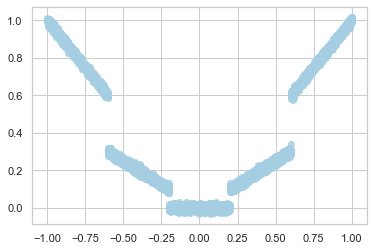

In [2]:
low_plot, high_plot, num_partitions_plot = -1, 1, 5
x_plot = np.random.uniform(low_plot, high_plot, 10000).reshape(-1, 1)
y_plot = f(x_plot, low_plot, high_plot, num_partitions_plot, 0, .01,
              alpha_min=-1, alpha_max=1)
sns.regplot(x_plot.ravel(), y_plot.ravel(), fit_reg=False)

Já para o treinamento dos modelos, utilizaremos as seguintes configurações:
- **Quantidade de features** = 2
- **Quantidade de modelos/partições** = 25
- **Observações**:
 - Quantidade = 100000
 - Intervalo = [-1, 1]
- **Ajuste de modelo**:
  - Percentual de treino, validação e teste respectivamente igual a .5, .3 e .2.
- **Função**:
  - Alphas variando entre 1 e 3.
  - Erro $\varepsilon \in \mathcal{N}(0, 0.01)$

In [3]:
# número de features, observações e modelos
d = 2
n = 100000
m = 25

# Input shape do modelo
input_shape = (d, )

# intervalo de X
low = -1
high = 1

# amostra uniforme entre low e high de tamanho n*d
x = np.random.uniform(low, high, n * d)

# Ordenação de x a fim de garantir o item .4
x = np.reshape(np.sort(x), newshape=(n, d))

# Configurações para o treinamento dos modelos
val_size = .3
test_size = .2

# Prefixo de nome associado a cada modelo
model_name_prefix = 'my_elastic_net'

# Onde os modelos e dados serão salvos
output_dir = os.path.join(parent_dir, 'saved_models_elastic_net')

# Configuração da função
f_alpha_min = 1 
f_alpha_max = 3
f_mean = 0
f_std = 10e-2

**Na célula abaixo é instanciada uma fábrica de modelos. A fábrica ('model_factory') ficará responsável por:**
1. Criar o vetor y com base na função f descrita anteriormente;
2. Dividir x em m partições;
3. Treinar cada modelo na sua devida partição;
4. Treinar um modelo em todo o domínio;
5. Salvar os modelos;
6. Salvar os dados.

In [4]:
f_config = dict(low=low, high=high, num_partitions=m, mean=f_mean, std=f_std,
                alpha_min=f_alpha_min, alpha_max=f_alpha_max)

model_config = dict(input_shape=input_shape, loss=tf.keras.losses.mean_squared_error, 
                    metrics=[tf.keras.metrics.mean_squared_error],epochs=10)

model_factory = ModelFactory(model_class=ElasticNet, x=x, f_x=f, num_models=m,
                             test_size=test_size, val_size=val_size,
                             model_name_prefix=model_name_prefix,
                             f_kwargs=f_config, model_kwargs=model_config)

model_factory.build_models()
model_factory.fit_models()

Building models: 100%|██████████| 25/25 [00:01<00:00, 22.62it/s]
Training models by partition: 25it [00:41,  1.66s/it]
Training a model in the whole domain: 100%|██████████| 1/1 [00:34<00:00, 34.51s/it]


Abaixo é computado o erro quadrático médio de cada modelo em cada partição e no domínio completo.

In [6]:
# Salvar modelos e dados
info = model_factory.get_metric_info()

model_factory.save_models(output_dir)
model_factory.save_data(output_dir, info)

Building metric matrices: 26it [01:40,  3.88s/it]


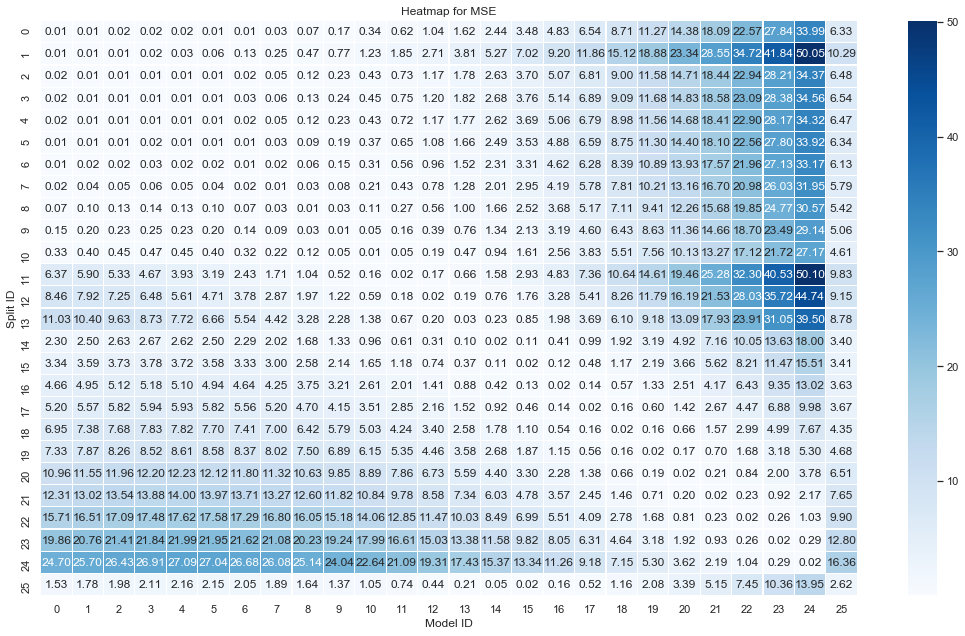

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)

matrix = info['mean_squared_error']

plot_heatmap(matrix=matrix, title=f'Heatmap for MSE', x_label='Model ID', y_label='Split ID', ax=ax,
             heatmap_kwargs=dict(linewidths=.1, cmap='Blues', annot=True, fmt='.2f'))
fig.tight_layout()

Obs.: A coluna mais à direita e linha mais abaixo dizem respeito respectivamente ao conjunto de teste e modelo treinado no domínio completo.

Note no plot acima que quanto mais distante da partição em que o modelo foi treinado, maior o erro que o modelo obtém na predição. Por exemplo, o modelo 24 obtém MSE de mais de 50 para partição 1 enquanto menor que 1 para partição 24.